
# HELOC Risk Prediction


### Introduction

This project aims at developing a predictive model and a decision support system (DSS) that evaluates the risk of Home Equity Line of Credit (HELOC) applications. 

I was assigned with a real-world financial dataset from FICO.The 23 predictor variables are either quantitative or categorical. The target variable that I am going to predict is a binary variable called RiskPerformance. The value “Bad” means that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. 

### Import Library

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score

### Load the data 

In [28]:
heloc = pd.read_csv('heloc_dataset_v1.csv')
heloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

In [29]:
heloc.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [30]:
heloc.columns

Index(['RiskPerformance', 'ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

### Data Cleaning and Data Preprocessing

#### Dealing with missing values and categorical variables

The target variable to predict is the RiskPerformance. The original data consists of two values: good and bad. RiskPeformance is factorized to 0 and 1. 0 represents bad and 1 represents good.

In [31]:
heloc['RiskPerformance']=pd.factorize(heloc['RiskPerformance'])[0]

split X and y

In [32]:
X = heloc.drop(["RiskPerformance"], axis=1)
y = heloc["RiskPerformance"]

convert MaxDelq2PublicRecLast12M and MaxDelqEver into categoricla variables using get_dummies

In [33]:
categorical1 = pd.get_dummies(X['MaxDelq2PublicRecLast12M'],prefix='MaxDelq2PublicRecLast12M')
categorical2 = pd.get_dummies(X['MaxDelqEver'],prefix='MaxDelqEver')

In [34]:
X.drop(['MaxDelq2PublicRecLast12M', 'MaxDelqEver'], axis=1, inplace=True)

-7,-8,-9 that represent missing values for different reasons are converted into binary variables.replace these negative values with the mode value of each variable.

In [35]:
def get_special(data, col):
  
   data[col + '_-7'] = data[col].apply(lambda row:int(row==-7))
   data[col + '_-8'] = data[col].apply(lambda row:int(row==-8))
   data[col + '_-9'] = data[col].apply(lambda row:int(row==-9))

for col in X.columns:
    get_special(X, col)
    
X[X < 0] = np.nan

In [36]:
imputer = SimpleImputer(strategy="most_frequent")
for i in range(0,23):
    X.iloc[:, [i]] = imputer.fit_transform(X.iloc[:, [i]])

In [37]:
X = pd.concat([X, categorical1,categorical2], axis=1)

#### Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddda4ca790>,
      dtype=object)

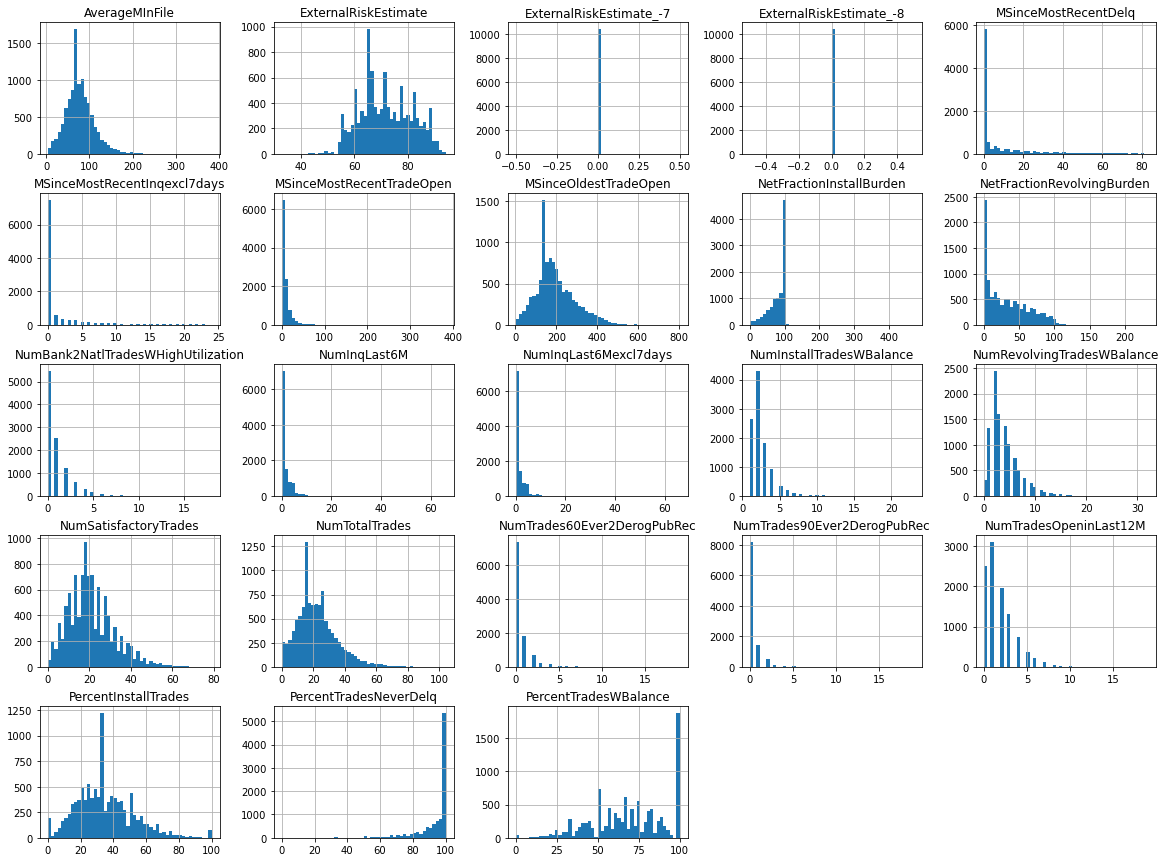

In [39]:
X.iloc[:,0:23].hist(bins=50, figsize=(20,15))

From the charts above, we could see measurement unit of each feature of the system are different.Thus,we need to standardize features using standard scaler for some machine learning models that are sensitive to the scale of the number.

### Building and Tuning Model

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree  
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
model_names = ['LR','LDA','SVM','KNN','DT','RF','GB','LGB']


param_grid_lr = [{'C':[0.01,0.1,1],'random_state':[1]}]
param_grid_dt =[{ 'max_features':range(1,20),'max_depth':range(1,50),'random_state':[1]}]
param_grid_rf = [{ 'n_estimators':[50, 100,150,200],'max_features':[0.2, 0.3, 0.5, 0.8], 'bootstrap':[True],'random_state':[1]}]
param_grid_gb= [{ 'n_estimators': [25, 50, 80, 100, 200],
                 'learning_rate': [.05, .1, .2,.5,1], 
                 'max_depth': [1,3,5],
                 'random_state':[1]}]
param_grid_lda = [{}]
param_grid_knn =[{},{'n_neighbors':[1,2,3,4,5]}]  
param_grid_lgb=[{'learning_rate': [0.001,0.003,0.01,0.05,0.051, 0.052, 0.055],'objective':['binary'],'metric':['binary_logloss'],'boosting_type':['goss'],'max_depth':[5],'num_leaves':[10]}]
param_grid_svm=[{'kernel':['linear', 'rbf'],'C': [0.1,0.5,1]}]

classifiers= [(LogisticRegression(), model_names[0], param_grid_lr),
              (LinearDiscriminantAnalysis(), model_names[1], param_grid_lda),
              (SVC(gamma='auto',probability=True),model_names[2],param_grid_svm),
            (neighbors.KNeighborsClassifier(), model_names[3], param_grid_knn),
            (tree.DecisionTreeClassifier(), model_names[4], param_grid_dt),
            (RandomForestClassifier(), model_names[5], param_grid_rf),
            (GradientBoostingClassifier(), model_names[6], param_grid_gb),
             (LGBMClassifier(),model_names[7],param_grid_lgb)]



def evaluate_model(X_train,X_test,y_train, y_test, model, model_name, params):   
    grid_search = GridSearchCV(model, params, cv=5,n_jobs=-1,scoring='roc_auc') 
    grid_search.fit(X_train,y_train)
       
    model_selection = grid_search.best_estimator_ 
    prob = model_selection.predict_proba(X_test)
    pred = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    AUC = auc(fpr, tpr)
    model_dic = {} 
    model_dic['Classifier'] = model_name 
    model_dic['Best Parameter'] = grid_search.best_estimator_.get_params()
    model_dic['CV AUC'] = grid_search.best_score_ 
    model_dic['Overall AUC'] = AUC
    return model_dic
  


In [43]:
res_list = []
for i in range(len(classifiers)):
    if i<4:
        #scale data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test= scaler.transform(X_test)
        res_list.append(evaluate_model(X_train,X_test,y_train, y_test, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    else:
        res_list.append(evaluate_model(X_train,X_test,y_train, y_test, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    
result_table = pd.DataFrame(res_list).sort_values(by=['Classifier']).reset_index(drop=True)
    
    
result_table

,Classifier,Best Parameter,CV AUC,Overall AUC
0,DT,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.754654,0.755777
1,GB,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.796575,0.794424
2,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.714300,0.719738
3,LDA,"{'n_components': None, 'priors': None, 'shrink...",0.796249,0.795001
4,LGB,"{'boosting_type': 'goss', 'class_weight': None...",0.796196,0.795756
5,LR,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.796323,0.794615
6,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.790762,0.794214
7,SVM,"{'C': 0.5, 'break_ties': False, 'cache_size': ...",0.790268,0.787654


In [44]:
result_table.iloc[4,1]

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.052,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss'}

In [48]:
def plot(model, plotROC=False):
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)
    pred = prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    # Find optimal threshold
    rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
    rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
    optimalthreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]
    
    
    # Get accuracy over the test set
    y_pred = np.where(pred >= optimalthreshold, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    if plotROC:
        plt.title('AUC_ROC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

AUC: 0.7958
Accuracy: 72.75%


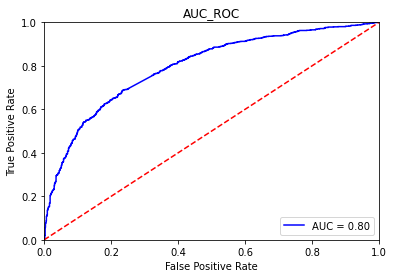

In [49]:
lgb_model = LGBMClassifier(learning_rate=0.052, objective='binary',metric='binary_logloss',
                       boosting_type='goss', max_depth=5, num_leaves=10)
plot(lgb_model,plotROC=True)

In [51]:
imp=pd.DataFrame()
imp['imp'] = lgb_model.feature_importances_
imp['name'] = lgb_model.feature_name_ 
imp=imp.sort_values(by=['imp'],ascending=False)
imp


,imp,name
0,116,Column_0
4,92,Column_4
3,88,Column_3
15,74,Column_15
1,63,Column_1
...,...,...
44,0,Column_44
43,0,Column_43
42,0,Column_42
41,0,Column_41


In [52]:
for i in X.columns[[0,4,3,15,1]]:
    print(i)

ExternalRiskEstimate
NumSatisfactoryTrades
AverageMInFile
NetFractionRevolvingBurden
MSinceOldestTradeOpen
